In [ ]:
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
rating_dir = os.path.join(os.path.dirname(os.getcwd()), "data/ml-10M100K/ratings.csv")
movie_dir = os.path.join(os.path.dirname(os.getcwd()), "data/ml-10M100K/movies.csv")

In [9]:
dfm = pd.read_csv(movie_dir, sep=',', engine='python', on_bad_lines='skip',nrows=1000)
df = pd.read_csv(rating_dir, nrows=10000)

In [10]:
df = df.merge(dfm, on='item', how='left')
df = df.sort_values(['user', 'timestamp'], ascending=[True, True]).reset_index(drop=True)
df.head(3)

user  item  values  timestamp                 title  \
0     1   588     5.0  838983339        Aladdin (1992)   
1     1   231     5.0  838983392  Dumb & Dumber (1994)   
2     1   316     5.0  838983392       Stargate (1994)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Musical  
1                                       Comedy  
2                      Action|Adventure|Sci-Fi

In [11]:
dfm.shape

(770, 3)

In [12]:
df.shape

(10000, 6)

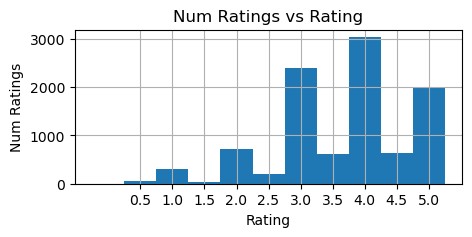

In [13]:
plt.figure(figsize=(5,2))
bins = np.arange(0,6,0.5)-0.25
plt.hist(df['values'].values, bins=bins)
plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.title('Num Ratings vs Rating')
plt.xlabel('Rating')
plt.ylabel('Num Ratings')
plt.grid()

In [14]:
d = defaultdict(LabelEncoder)

In [15]:
cols_cat = ['user', 'item']
for c in cols_cat:
    d[c].fit(df[c].unique())
    df[c] = d[c].transform(df[c])
    print(f'# unique {c}: {len(d[c].classes_)}')

# unique user: 84
# unique item: 2976


In [16]:
min_num_ratings = df.groupby(['user'])['user'].transform(len).min()
print(f'Min # of ratings per user: {min_num_ratings}')
print(f'Min/Max rating: {df["values"].min()}/{df["values"].max()}, df.shape: {df.shape}')
df.head(3)

Min # of ratings per user: 20
Min/Max rating: 0.5/5.0, df.shape: (10000, 6)


user  item  values  timestamp                 title  \
0     0   369     5.0  838983339        Aladdin (1992)   
1     0   148     5.0  838983392  Dumb & Dumber (1994)   
2     0   199     5.0  838983392       Stargate (1994)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Musical  
1                                       Comedy  
2                      Action|Adventure|Sci-Fi

In [17]:
df_train = df.groupby('user').head(-5).reset_index(drop=True)
df_val = df.groupby('user').tail(5).reset_index(drop=True)
print(df_train.shape, df_val.shape)


(9580, 6) (420, 6)


In [18]:
class MovieDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df[['user', 'item', 'values']]
        self.x_user_movie = list(zip(df.user.values, df.item.values))
        self.y_rating = self.df['values'].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.x_user_movie[idx], self.y_rating[idx]

In [19]:
BS = 8192
ds_train = MovieDataset(df_train)
ds_val = MovieDataset(df_val)
dl_train = DataLoader(ds_train, BS, shuffle=True, num_workers=4)
dl_val = DataLoader(ds_val, BS, shuffle=True, num_workers=4)

xb, yb = next(iter(dl_train))
print(xb)
print(yb)

[tensor([24, 43, 49,  ..., 56,  7, 44]), tensor([1971,  712, 1604,  ...,  671,  841, 2340])]
tensor([2.0000, 5.0000, 5.0000,  ..., 3.0000, 3.5000, 2.0000],
       dtype=torch.float64)


Each user and movie (item) is put through an nn.Embedding layer. This layer creates the vector representation. Then the user_emb and item_emb vectors are multiplied together and summed (equivalent to a dot product).

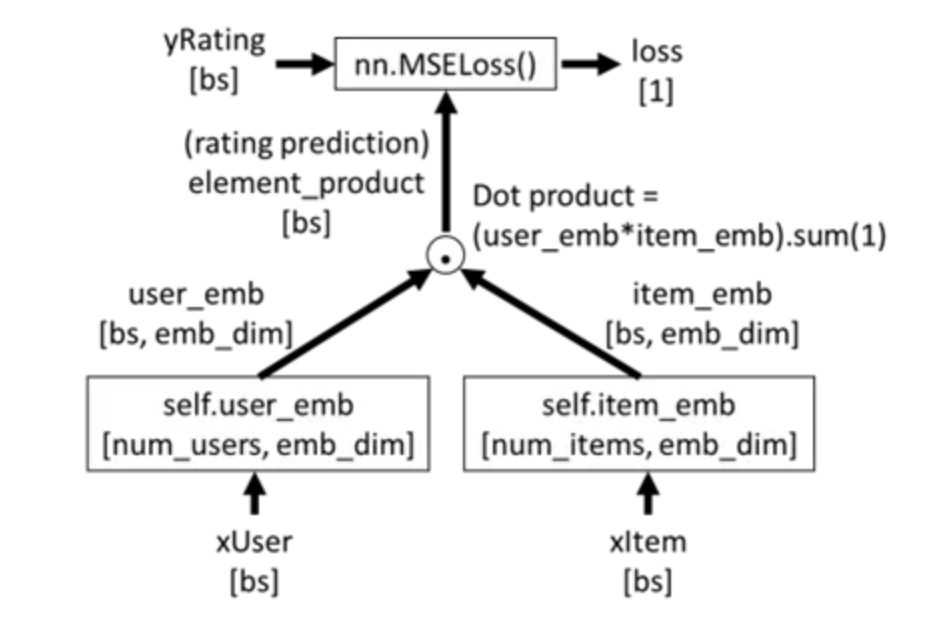

In [20]:
class MF(nn.Module):
    """ Matrix factorization model simple """
    def __init__(self, num_users, num_items, emb_dim):
        super().__init__()
        self.user_emb = nn.Embedding(num_embeddings=num_users, embedding_dim=emb_dim)
        self.item_emb = nn.Embedding(num_embeddings=num_items, embedding_dim=emb_dim)
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)
        element_product = (user_emb*item_emb).sum(1)
        return element_product

In [21]:
n_users = len(df.user.unique())
n_items = len(df.item.unique())
mdl = MF(n_users, n_items, emb_dim=32)
mdl.to(device)
print(mdl)

MF(
  (user_emb): Embedding(84, 32)
  (item_emb): Embedding(2976, 32)
)


In [25]:
LR = 0.2
NUM_EPOCHS = 50

opt = optim.AdamW(mdl.parameters(), lr=LR)
loss_fn = nn.MSELoss()
epoch_train_losses, epoch_val_losses = [], []

for i in range(NUM_EPOCHS):
    train_losses, val_losses = [], []
    mdl.train()
    for xb,yb in dl_train:
        xUser = xb[0].to(device, dtype=torch.long)
        xItem = xb[1].to(device, dtype=torch.long)
        yRatings = yb.to(device, dtype=torch.float)
        preds = mdl(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        train_losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    mdl.eval()
    for xb,yb in dl_val:
        xUser = xb[0].to(device, dtype=torch.long)
        xItem = xb[1].to(device, dtype=torch.long)
        yRatings = yb.to(device, dtype=torch.float)
        preds = mdl(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        val_losses.append(loss.item())
    # Start logging
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)
    print(f'Epoch: {i}, Train Loss: {epoch_train_loss:0.1f}, Val Loss:{epoch_val_loss:0.1f}')

Epoch: 0, Train Loss: 2.8, Val Loss:15.1
Epoch: 1, Train Loss: 4.4, Val Loss:13.6
Epoch: 2, Train Loss: 3.7, Val Loss:12.3
Epoch: 3, Train Loss: 2.5, Val Loss:10.7
Epoch: 4, Train Loss: 2.6, Val Loss:9.6
Epoch: 5, Train Loss: 1.9, Val Loss:8.7
Epoch: 6, Train Loss: 1.6, Val Loss:8.0
Epoch: 7, Train Loss: 1.4, Val Loss:7.4
Epoch: 8, Train Loss: 1.2, Val Loss:7.0
Epoch: 9, Train Loss: 1.0, Val Loss:6.6
Epoch: 10, Train Loss: 0.9, Val Loss:6.2
Epoch: 11, Train Loss: 0.8, Val Loss:6.0
Epoch: 12, Train Loss: 0.7, Val Loss:6.0
Epoch: 13, Train Loss: 0.6, Val Loss:6.0
Epoch: 14, Train Loss: 0.6, Val Loss:5.8
Epoch: 15, Train Loss: 0.5, Val Loss:5.7
Epoch: 16, Train Loss: 0.4, Val Loss:5.6
Epoch: 17, Train Loss: 0.4, Val Loss:5.5
Epoch: 18, Train Loss: 0.4, Val Loss:5.4
Epoch: 19, Train Loss: 0.3, Val Loss:5.3
Epoch: 20, Train Loss: 0.3, Val Loss:5.1
Epoch: 21, Train Loss: 0.3, Val Loss:5.0
Epoch: 22, Train Loss: 0.3, Val Loss:4.9
Epoch: 23, Train Loss: 0.2, Val Loss:4.9
Epoch: 24, Train Loss:

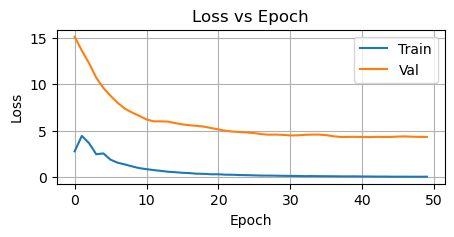

In [26]:
plt.figure(figsize=(5,2))
plt.plot(epoch_train_losses, label='Train')
plt.plot(epoch_val_losses, label='Val')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend();

In [27]:
user_emb_min_w = mdl.user_emb.weight.min().item()
user_emb_max_w = mdl.user_emb.weight.max().item()
item_emb_min_w = mdl.item_emb.weight.min().item()
item_emb_max_w = mdl.item_emb.weight.max().item()
print(f'Emb user min/max w: {user_emb_min_w:0.3f} / {user_emb_max_w:0.3f}')
print(f'Emb item min/max w: {item_emb_min_w:0.3f} / {item_emb_max_w:0.3f}')
print(f'Preds min/max: {preds.min().item():0.2f} / {preds.max().item():0.2f}')
print(f'Rating min/max: {yRatings.min().item():0.2f} / {yRatings.max().item():0.2f}')
print(preds.detach().cpu().numpy()[:6])
print(yRatings.detach().cpu().numpy()[:6])

Emb user min/max w: -1.401 / 1.171
Emb item min/max w: -5.268 / 5.518
Preds min/max: -2.99 / 6.17
Rating min/max: 0.50 / 5.00
[-1.9047128  1.0599533  3.2028203  1.5771877 -0.8685765  4.365226 ]
[4.  1.  3.  3.  3.5 3. ]
